In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

2023-10-07 00:02:23.054094: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-07 00:02:23.055715: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-07 00:02:23.087707: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-07 00:02:23.088493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-07 00:02:24.839705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:


def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def window_dataset(series, window_size, batch_size=128,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [3]:
df = yf.download('AAPL',start='2000-01-01',end='2023-09-01')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.848323,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.776801,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.788168,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.719961,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.754065,460734400
...,...,...,...,...,...,...
2023-08-25,177.380005,179.149994,175.820007,178.610001,178.610001,51449600
2023-08-28,180.089996,180.589996,178.550003,180.190002,180.190002,43820700
2023-08-29,179.699997,184.899994,179.500000,184.119995,184.119995,53003900


In [4]:
# Read in data



spy = pd.read_csv('SPY.csv')

# Convert series into datetime type
spy['Date'] = pd.to_datetime(spy['Date'])

# Save target series
series = spy['Close']

# Create train data set
train_split_date = '2020-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2021-04-21'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

5283 5284 5357 5358 5958


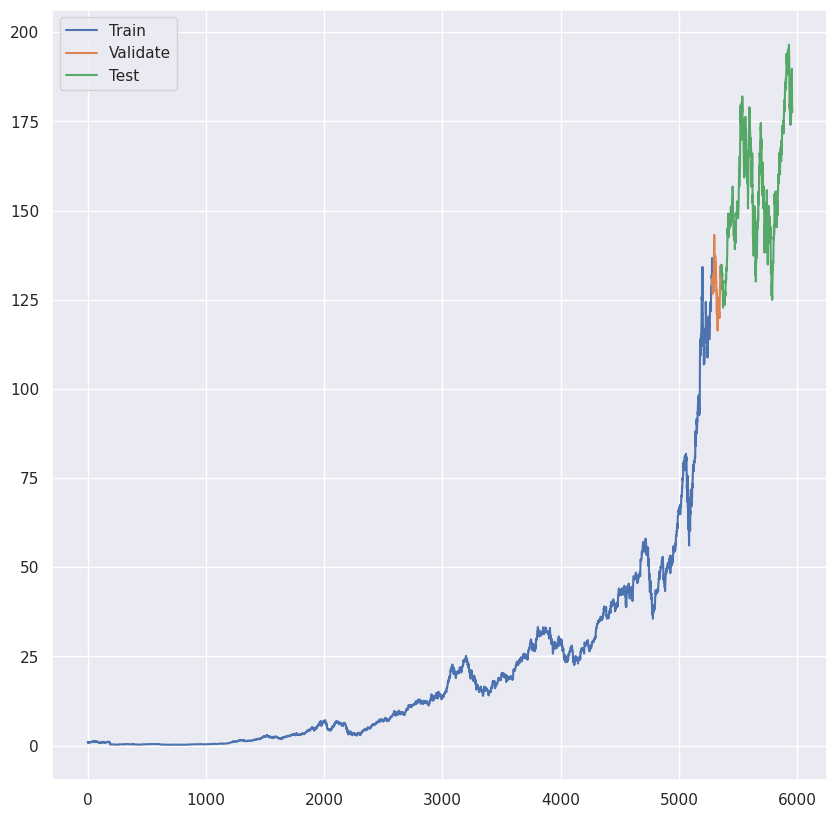

In [5]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [6]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = window_dataset(normalized_x_train.flatten(), window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.Adam(lr=1e-7)  # Change to Adam optimizer
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
42/42 [==============================] - 5s 92ms/step - loss: 1.3063e-04 - mae: 0.0074 - lr: 1.0000e-07
Epoch 2/100
42/42 [==============================] - 2s 58ms/step - loss: 1.3056e-04 - mae: 0.0074 - lr: 1.1220e-07
Epoch 3/100
42/42 [==============================] - 2s 38ms/step - loss: 1.3048e-04 - mae: 0.0074 - lr: 1.2589e-07
Epoch 4/100
42/42 [==============================] - 2s 45ms/step - loss: 1.3040e-04 - mae: 0.0074 - lr: 1.4125e-07
Epoch 5/100
42/42 [==============================] - 2s 40ms/step - loss: 1.3031e-04 - mae: 0.0074 - lr: 1.5849e-07
Epoch 6/100
42/42 [==============================] - 3s 55ms/step - loss: 1.3022e-04 - mae: 0.0074 - lr: 1.7783e-07
Epoch 7/100
42/42 [==============================] - 3s 50ms/step - loss: 1.3013e-04 - mae: 0.0074 - lr: 1.9953e-07
Epoch 8/100
42/42 [==============================] - 2s 46ms/step - loss: 1.3008e-04 - mae: 0.0074 - lr: 2.2387e-07
Epoch 9/100
42/42 [==============================] - 2s 39ms/step - loss

In [8]:
keras.backend.clear_session()

# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Set Window Size
window_size = 30
train_set = window_dataset(normalized_x_train.flatten(), window_size)
valid_set = window_dataset(normalized_x_valid.flatten(), window_size)

# Build 2 layer model with 10 neurons each and 1 output layer
model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

# Set optimizer
optimizer = keras.optimizers.Adam(lr=1e-2)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Set early Stopping
early_stopping = keras.callbacks.EarlyStopping(patience=20)

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# Fit model
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
     39/Unknown - 3s 39ms/step - loss: 0.0114 - mae: 0.0892INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


42/42 [==============================] - 4s 73ms/step - loss: 0.0127 - mae: 0.0949 - val_loss: 0.1729 - val_mae: 0.5869
Epoch 2/500
40/42 [===========================>..] - ETA: 0s - loss: 0.0056 - mae: 0.0860INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


42/42 [==============================] - 3s 58ms/step - loss: 0.0057 - mae: 0.0864 - val_loss: 0.0465 - val_mae: 0.3017
Epoch 3/500
34/42 [=======================>......] - ETA: 0s - loss: 0.0026 - mae: 0.0671INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


42/42 [==============================] - 2s 49ms/step - loss: 0.0028 - mae: 0.0657 - val_loss: 0.0077 - val_mae: 0.1136
Epoch 4/500
40/42 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0431INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


42/42 [==============================] - 2s 54ms/step - loss: 0.0011 - mae: 0.0428 - val_loss: 0.0023 - val_mae: 0.0516
Epoch 5/500
35/42 [========================>.....] - ETA: 0s - loss: 2.0789e-04 - mae: 0.0173INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


42/42 [==============================] - 3s 55ms/step - loss: 2.7535e-04 - mae: 0.0182 - val_loss: 0.0015 - val_mae: 0.0464
Epoch 6/500
42/42 [==============================] - 2s 39ms/step - loss: 1.4871e-04 - mae: 0.0113 - val_loss: 0.0018 - val_mae: 0.0531
Epoch 7/500
42/42 [==============================] - 2s 44ms/step - loss: 1.4812e-04 - mae: 0.0112 - val_loss: 0.0018 - val_mae: 0.0519
Epoch 8/500
42/42 [==============================] - 2s 37ms/step - loss: 1.2449e-04 - mae: 0.0093 - val_loss: 0.0023 - val_mae: 0.0597
Epoch 9/500
42/42 [==============================] - 2s 31ms/step - loss: 1.2806e-04 - mae: 0.0098 - val_loss: 0.0019 - val_mae: 0.0548
Epoch 10/500
42/42 [==============================] - 2s 33ms/step - loss: 1.1840e-04 - mae: 0.0091 - val_loss: 0.0021 - val_mae: 0.0579
Epoch 11/500
42/42 [==============================] - 2s 34ms/step - loss: 1.1409e-04 - mae: 0.0088 - val_loss: 0.0021 - val_mae: 0.0578
Epoch 12/500
42/42 [==============================] - 2s 3

In [9]:
model = keras.models.load_model("my_checkpoint")

In [10]:
dense_forecast = model_forecast(model, spy_normalized_to_traindata.flatten()[x_test.index.min() - window_size:-1], window_size)[:, 0]

19/19 [==============================] - 0s 12ms/step


In [11]:
spy_normalized_to_traindata.flatten().shape

(5959,)

In [12]:
# Undo the scaling
dense_forecast = x_train_scaler.inverse_transform(dense_forecast.reshape(-1,1)).flatten()
dense_forecast.shape


(601,)

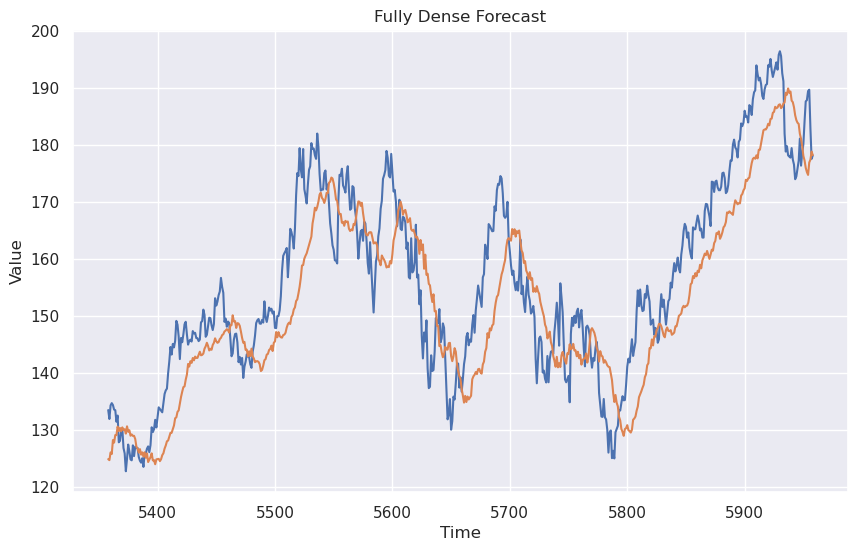

In [13]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

plt.figure(figsize=(10, 6))
plt.title('Fully Dense Forecast')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plot_series(x_test.index, x_test)
plot_series(x_test.index, dense_forecast)

In [14]:
keras.metrics.mean_absolute_error(x_test, dense_forecast).numpy()

7.7995667